# __Step 4.2: Topic model outlier__

BERTopic 
- [Step-by-step](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6)
- [Deal with situation where most docs are in the -1 topic](https://github.com/MaartenGr/BERTopic/issues/485)

Goals here:
- Choose SciBERT to proceed as it has the fewest docs that cannot be assigned to topics in the initial model:
  - distillbert: 323846
  - scibert: 268848
  - biobert: 293790
- Rerun BERTopic with scibert with a different parameter setting compared to the intial one (4_1).
  - size of outlier cluser (-1): 241567
- Assess probability distributions and establish a threshold p-value for assignment unassigned docs (outliers) to topics. With probability treshold of:
  - 0.0067 (~75 percentiles): topic(-1)=34622
  - 0.0155 (~95 percentiles): topic(-1)=49228 <-- go with this...
    - At this threshold, 11.7% of the documents are not assigned to topic.
  - 0.0434 (~99 percentiles): topic(-1)=124648 
- Apply the threshold and generate an updated model. 

## ___Set up___

### Module import

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from bertopic import BERTopic

# Added this 10/4/22, not sure why this is not in before
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

### Key variables

In [2]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "4_topic_model/4_2_outlier_assign"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"

# processed docs
dir41            = proj_dir / "4_topic_model/4_1_compare_models"
docs_clean_file  = dir41 / "corpus_plant_421658_proc_txt.pkl"

# embedding model
emb_model_name = "allenai/scibert_scivocab_uncased" 


## ___Load data___

### Load cleaned data and topic model

In [3]:
with open(docs_clean_file, "rb") as f:
  docs_clean = pickle.load(f)

In [4]:
len(docs_clean), docs_clean[0]

(421658,
 'identification 120 mus phase decay delayed fluorescence spinach chloroplasts subchloroplast particles intrinsic back reaction . dependence level phase thylakoids internal ph . 500 mus laser flash 120 mus phase decay delayed fluorescence visible variety circumstances spinach chloroplasts subchloroplast particles enriched photosystem ii prepared means digitonin . level phase high case inhibition oxygen evolution donor side photosystem ii . comparison results babcock sauer ( 1975 ) biochim . bio-phys . acta 376 , 329-344 , indicates epr signal iif suppose due z+ , oxidized first secondary donor photosystem ii , well correlated large amplitude 120 mus phase . explain 120 mus phase intrinsic back reaction excited reaction center presence z+ , predicted van gorkom donze ( 1973 ) photochem . photobiol . 17 , 333-342. redox state z+ dependent internal ph thylakoids . results effect ph mus region compared obtained ms region .')

### Get doc embeddings 

In [ ]:
# Generate embeddings
emb_model  = SentenceTransformer(emb_model_name)
embeddings = emb_model.encode(docs_clean, show_progress_bar=True)
# Output embeddings
with open(work_dir / "embeddings_scibert.pickle", "wb") as f:
  pickle.dump(embeddings, f)

In [5]:
# Load embeddings
with open(work_dir / "embeddings_scibert.pickle", "rb") as f:
  embeddings = pickle.load(f)

In [6]:
type(embeddings), embeddings.shape

(numpy.ndarray, (421658, 768))

## ___Run BERTopic___

### Set parameters

In [7]:
# HDBSCAN clustering setting
min_cluster_size         = 500 
metric                   = 'euclidean' 
cluster_selection_method ='eom' 
prediction_data          = True 
min_samples              = 5

# BERTopic setting
calculate_probabilities = True
n_neighbors             = 10  
nr_topics               = 500
n_gram_range            = (1,2)

### Initialize HDBSCAN

For reducing outliers, following [this instruction](https://maartengr.github.io/BERTopic/faq.html#how-do-i-reduce-topic-outliers)
- Also see [HDBSCAN doc](https://hdbscan.readthedocs.io/en/latest/basic_hdbscan.html#what-about-different-metrics)
- Comparison of [distance metrics](https://www.kdnuggets.com/2019/01/comparison-text-distance-metrics.html)

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, 
                        metric=metric, 
                        cluster_selection_method=cluster_selection_method, 
                        prediction_data=prediction_data, 
                        min_samples=min_samples)

### Intialize and train topic model

In [ ]:
topic_model = BERTopic(hdbscan_model=hdbscan_model,
                       calculate_probabilities=calculate_probabilities,
                       n_gram_range=n_gram_range,
                       nr_topics=nr_topics,
                       verbose=True)

In [ ]:
topics, probs = topic_model.fit_transform(docs_clean,
                                          embeddings)

### Save model, topics, and probability

In [ ]:
# I already save the embeddings, so won't save it again
topic_model.save(work_dir / 'topic_model')

with open(work_dir / 'probs.pickle', "wb") as f:
  pickle.dump(probs, f)

### Load model and probabilities

In [8]:
# Load topic model
topic_model = BERTopic.load(work_dir / 'topic_model')

In [9]:
# load prob
with open(work_dir / 'probs.pickle', "rb") as f:
  probs = pickle.load(f)

In [10]:
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name
0,-1,241567,-1_plant_plants_species_growth
1,0,919,0_allergen_allergens_pollen_ige
2,1,3976,1_medium_callus_regeneration_culture
3,2,1111,2_dots_fluorescence_detection_carbon dots
4,3,859,3_glyphosate_herbicide_resistance_herbicides
...,...,...,...
86,85,825,85_soil_yield_nitrogen_fertilizer
87,86,567,86_inbreeding_depression_inbreeding depression...
88,87,2828,87_pollen_pollination_flowers_floral
89,88,1849,88_populations_genetic_diversity_genetic diver...


## ___Assign outliers to topics___

### Determine probability distributions

In [11]:
probs.shape, probs[:,0].shape

((421658, 90), (421658,))

In [12]:
# Cluster 0
pd.DataFrame(probs[:,0]).describe()

,0
count,4.216580e+05
mean,4.686914e-03
std,3.724943e-02
min,4.414574e-308
25%,1.323693e-03
50%,2.881805e-03
75%,4.384614e-03
max,1.000000e+00


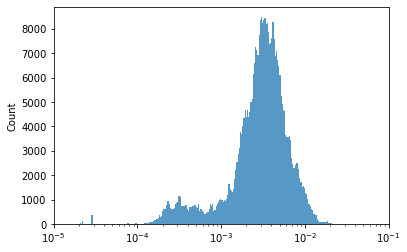

In [13]:
sns.histplot(probs[:,0], log_scale=True)
plt.xlim(1e-5, 1e-1)
plt.savefig(work_dir / "fig4_2_prob_cluster0.pdf", bbox_inches='tight')

In [14]:
# Cluster 1
pd.DataFrame(probs[:,1]).describe()

,0
count,4.216580e+05
mean,6.411141e-03
std,4.244737e-02
min,5.014457e-308
25%,1.727241e-03
50%,4.033303e-03
75%,5.625952e-03
max,1.000000e+00


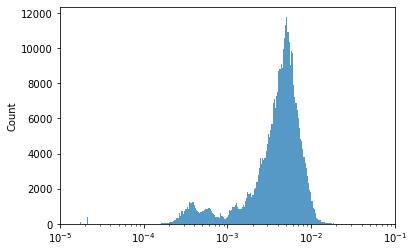

In [15]:
sns.histplot(probs[:,1], log_scale=True)
plt.xlim(1e-5, 1e-1)
plt.savefig(work_dir / "fig4_2_prob_cluster1.pdf", bbox_inches='tight')

In [16]:
topic_freq = topic_model.get_topic_freq()
topic_freq

,Topic,Count
0,-1,241567
1,61,11209
2,12,8942
3,69,7685
4,35,6913
...,...,...
86,30,522
87,25,508
88,78,506
89,38,503


### Test: get prediction score distributions of records assigned to topic 0

In [19]:
topic_info.head(2)

,Topic,Count,Name
0,-1,241567,-1_plant_plants_species_growth
1,0,919,0_allergen_allergens_pollen_ige


In [22]:
# Get the top x probabilities for each topic based on counts
# Test on topic 0
topic       = 0

# Topic count from the topic_info table
topic_count = topic_info["Count"].values[topic + 1]
topic_count

919

In [27]:
# probabilities for topic 0
topic_prob = probs[:,topic]

# Get top x probabilities, x=topic_count
#https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
#https://stackoverflow.com/questions/12518043/numpy-indexing-return-the-rest

# indices of top records
top_idx       = np.argpartition(topic_prob, -topic_count)[-topic_count:]
mask          = np.zeros(topic_prob.shape,dtype=bool)
mask[top_idx] = True

top_probs     = topic_prob[mask]
non_top_probs = topic_prob[~mask]
topic_prob.shape, top_probs.shape, non_top_probs.shape

((421658,), (919,), (420739,))

In [28]:
# Get range: 0 to 1
max(topic_prob), min(topic_prob)

(1.0, 4.4145743905191797e-308)

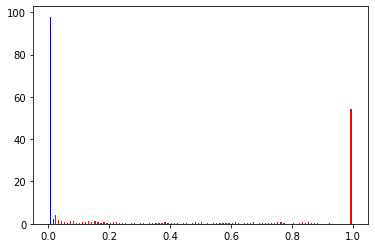

In [33]:
# Plot distributions
#https://stackoverflow.com/questions/47999159/normalizing-two-histograms-in-the-same-plot
plt.hist([top_probs, non_top_probs], 
         color=['r', 'b'], density=True, bins=100)
plt.show()

In [35]:
np.percentile(top_probs, 5), np.percentile(top_probs, 1)

(0.03433855245531285, 0.02369780620672858)

### Get the 5 and 1 percentile values of positive predictions of all topics

In [37]:
probs_5 = []
probs_1 = []
for topic in range(90):
  topic_count = topic_info["Count"].values[topic + 1]
  # probabilities for topic
  topic_prob = probs[:,topic]

  # Get top x probabilities, x=topic_count
  top_idx       = np.argpartition(topic_prob, -topic_count)[-topic_count:]
  mask          = np.zeros(topic_prob.shape,dtype=bool)
  mask[top_idx] = True
  top_probs     = topic_prob[mask]  # probabilities of top x
  non_top_probs = topic_prob[~mask] # probabilities of non-top x

  prob_5 = np.percentile(top_probs, 5)
  prob_1 = np.percentile(top_probs, 1)

  probs_5.append(prob_5)
  probs_1.append(prob_1)
  #print(f"{topic}: 5 perc={prob_5}, 1 perc={prob_1}")

In [40]:
np.median(probs_5), np.median(probs_1)

(0.14412717798176286, 0.12689914879118433)

### Assignments

In [9]:
# Get the overall probability values at three different percentiles
np.percentile(probs, 75), np.percentile(probs, 95), np.percentile(probs, 99)

(0.006735027420849654, 0.015512210159378426, 0.04337546078552455)

In [42]:
probability_threshold = np.percentile(probs, 95)
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 
                                                            for prob in probs]

In [43]:
pd.Series(new_topics).value_counts()

-1     49228
 61    16183
 35    13599
 81    10403
 79    10390
       ...  
 57      828
 21      789
 3       751
 66      673
 5       620
Length: 91, dtype: int64

In [44]:
49228/len(new_topics)

0.11674864463617433

### Update topics

See [this post](https://github.com/MaartenGr/BERTopic/issues/529):
- When update_topics the topic_model topics remain unchanged.
- Tunr out that I need to update topic size as well. This seems weird...
- Take me 2 hours to find this...


In [45]:
# ~8 min
topic_model.update_topics(docs_clean, new_topics)

In [46]:
# Update topic frequencies
documents = pd.DataFrame({"Document": docs_clean, "Topic": new_topics})
topic_model._update_topic_size(documents)

In [47]:
topic_info_changed = topic_model.get_topic_info()
topic_info_changed

,Topic,Count,Name
0,-1,49228,-1_plant_plants_genes_cell
1,0,895,0_allergen_allergens_pollen_ige
2,1,2917,1_medium_callus_regeneration_mgl
3,2,1098,2_dots_fluorescence_detection_carbon dots
4,3,751,3_glyphosate_resistance_herbicide_herbicides
...,...,...,...
86,85,5989,85_soil_yield_nitrogen_water
87,86,4315,86_populations_genetic_selection_inbreeding
88,87,3737,87_pollen_pollination_flowers_floral
89,88,3807,88_populations_genetic_population_species


In [17]:
topic_model.save(work_dir / 'topic_model_updated')

### Get updated topic info

In [48]:
# Load topic model
topic_model_updated = BERTopic.load(work_dir / 'topic_model_updated')

In [49]:
topic_info_updated = topic_model_updated.get_topic_info()
topic_info_updated

,Topic,Count,Name
0,-1,49228,-1_plant_plants_genes_cell
1,0,895,0_allergen_allergens_pollen_ige
2,1,2917,1_medium_callus_regeneration_mgl
3,2,1098,2_dots_fluorescence_detection_carbon dots
4,3,751,3_glyphosate_resistance_herbicide_herbicides
...,...,...,...
86,85,5989,85_soil_yield_nitrogen_water
87,86,4315,86_populations_genetic_selection_inbreeding
88,87,3737,87_pollen_pollination_flowers_floral
89,88,3807,88_populations_genetic_population_species


In [50]:
n_total     = np.sum(topic_info_updated['Count'].values)
n_outlier   = topic_info_updated['Count'][0]
n_in_topics = n_total - n_outlier
n_in_topics, n_in_topics/n_total*100

(372430, 88.32513553638258)

## ___Add additional columns to the corpus dataframe___

- cleaned text
- topic assignment

### Load corpus dataframe

In [55]:
# plant science corpus
dir25       = proj_dir / "2_text_classify/2_5_predict_pubmed"
corpus_file = dir25 / "corpus_plant_421658.tsv.gz"
corpus_df   = pd.read_csv(corpus_file, sep='\t', compression='gzip')
corpus_df.shape

(421658, 11)

In [58]:
corpus_df.rename(columns={'Unnamed: 0':'Index_1385417',
                          'QualifiedName':'Initial filter qualifier',
                          'reg article':'Regular article',
                          'y_prob':'Text classification score',
                          'y_pred':'Plant science record',
                          'txt':'Corpus'}, inplace=True)
corpus_df.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Plant science record
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,1
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,1


In [59]:
# All records in this dataframe are predicted to be plant science records. So
# the last column is not useful
corpus_df.drop('Plant science record', inplace=True, axis=1)

In [60]:
corpus_df.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874


### Add additional columns

In [52]:
# Check the cleaned doc has the correct order and dimension
len(docs_clean), docs_clean[0][:50], docs_clean[1][:50]

(421658,
 'identification 120 mus phase decay delayed fluores',
 'cholinesterases plant tissues . vi . preliminary c')

In [61]:
# Add docs_clean and new_topics
corpus_df['Preprocessed corpus'] = docs_clean
corpus_df['Topic'] = new_topics
corpus_df.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Preprocessed corpus,Topic
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,identification 120 mus phase decay delayed flu...,52
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,cholinesterases plant tissues . vi . prelimina...,48


In [62]:
# Save corpus_df
new_corpus_file = work_dir / "table4_2_corpus_with_topic_assignment.tsv.gz"
corpus_df.to_csv(new_corpus_file, sep='\t', compression='gzip')

: 